In [1]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None) 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import datetime
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy
import re
import xlrd
from datetime import date
from xlsxwriter.utility import xl_rowcol_to_cell
from random import sample 
from math import log10, floor
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, littleQA, totalUP
from src.data_models.SmartsDataModel import SmartsDataModel
from src.utility.DataModelUtility import execute_query_data_frame

account = 355845

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### 1) Import Alerts from SMARTS FE

In [2]:
alerts0 = fixNum(unSMART(pd.read_excel('~/Documents/datafldr/smarts1_2019JanFeb_spoof.xlsx')))

-> type fixed, kept 205 rows, 15 columns


In [3]:
alerts4022 = alerts0.loc[((alerts0['AlertCode'] == 4022) | (alerts0['AlertCode'] == 4023) | (alerts0['AlertCode'] == 4032)) & (alerts0['AccountIDName'] == account),['Date','InstrumentName','AlertID']].reset_index(drop=True)
alertsummary = alerts4022.groupby(['Date','InstrumentName']).count()['AlertID']
# alertsummary

### 2) Keep Account X/ Spoof Group Alerts

In [4]:
accdates = alerts4022.groupby(['Date','InstrumentName']).count().reset_index()
accdates['Datestr'] = accdates['Date'].astype(str).str.replace('-','')

### 3) Read in SMARTS csv files & Combine

In [5]:
inputdf = []

for i in range(0,accdates.shape[0]):
    inputt = pd.read_csv(f"~/Downloads/csv_archive/{accdates.loc[i,'Datestr']}.orders_{accdates.loc[i,'InstrumentName']}.csv")
    inputt['Date'] = accdates.loc[i,'Date']
    inputdf.append(inputt)

inputt = pd.concat(inputdf, sort=True)
inputt.columns = inputt.columns.str.replace(' ','')
inputt['dt'] = pd.to_datetime(inputt['EventDate'] + ' ' + inputt['EventTime'] + '.' + inputt['EventMillis'].apply(lambda x: '{0:0>3}'.format(x)))

#### >>> Account Analysis

In [6]:
metrics(inputt['AccountID']).head()

,count,%
355845,1792751,29%
1595,796479,13%
22440,745454,12%
411770,610815,10%
847194,550719,9%


#### >>> Order Type/Execution Analysis

In [7]:
inputt_acc = inputt.loc[inputt['AccountID'] == account].reset_index()
inputt_acc[['OrderID','ExecutionOptions','OrderType']].fillna('missing').groupby(['ExecutionOptions','OrderType']).count()

,,OrderID
ExecutionOptions,OrderType,
auction-only,limit,281
block,limit,354
maker-or-cancel,limit,1789856
missing,limit,2260


### 4) OrderID groupby

#### >>> Group by OrderID

In [8]:
data0_place = inputt_acc.loc[(inputt_acc['EventType'] == 'Place') & (inputt_acc['EventType'] == 'Place'),['OrderID','dt','Symbol']]
data0_cancel = inputt_acc.loc[inputt_acc['EventType'] == 'Cancel',['OrderID','dt']]
data0_fill = inputt_acc.loc[inputt_acc['EventType'] == 'Fill',['OrderID','dt']].groupby(['OrderID']).min()

data1 = pd.concat([data0_place.set_index(['OrderID']),data0_cancel.set_index(['OrderID']),data0_fill],axis=1)
data1.columns = ['place','pair','cancel','fill']
data1['canceltime'] = (data1['cancel'] - data1['place']).dt.total_seconds()/60
data1['filltime'] = (data1['fill'] - data1['place']).dt.total_seconds()/60
# data1

#### >>> OrderID check

### 5) Figure 1: Liquidity/Side Breakdown

In [9]:
query = """
        SELECT liquidity_indicator, side, count(*)
        from order_fill_event
        where created between '2019-01-01' and '2019-03-01' and account_id = {}
        group by liquidity_indicator, side;
        """.format(account)

test = execute_query_data_frame(query,'engine')
test2 = round(test.set_index(['liquidity_indicator','side'])/test.sum()['count']*100,0).astype(int)
totalUP(pd.pivot_table(test2.loc[test2['count'] > 0].reset_index(), values='count', index=['liquidity_indicator'], columns=['side'], aggfunc=np.sum)).to_csv('~/Desktop/Figure1{}.csv'.format(account))

INFO:root:Constructing Singleton
INFO:root:Using global configuration /Users/sqian/msv.yaml.
INFO:root:Completed loading configuration.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:01.174857


INFO:root:Loaded dataframe with 8 rows in 0:00:02.099229.


### 6) Figure 2: Combined CSV data for Alert days

In [10]:
data2 = data1.loc[~data1['place'].isna()]
data2['Date'] = data2['place'].dt.date

In [11]:
alertsummary.head()

Date        InstrumentName
2019-01-07  BTCUSD            2
2019-01-11  ETHUSD            2
            ZECUSD            1
2019-01-14  ZECUSD            1
2019-01-15  ETHUSD            2
Name: AlertID, dtype: int64

In [12]:
# data3 = pd.concat([alertsummary.reset_index().set_index(['Date','InstrumentName']),
#                    data2.set_index('Date').groupby(['Date','pair']).count()[['place','cancel','fill']]]
#                   ,axis=1).rename(columns={'canceltime':'within1m_cancel'})
# data3['fill%'] = round((1-data3['cancel']/data3['place'])*100,1).astype(str) +'%'
# data3['1sec_cancel'] = round(data2.groupby(['Date','pair'])['canceltime'].apply(stats.percentileofscore,1/60),1).astype(str) + '%'
# data3['1min_cancel'] = round(data2.groupby(['Date','pair'])['canceltime'].apply(stats.percentileofscore,1),1).astype(str) + '%'

In [13]:
round(data2.groupby([data2['place'].dt.month,'pair'])['canceltime'].apply(stats.percentileofscore,1/60),1).astype(str) + '%'

place  pair  
1      BTCUSD    45.6%
       ETHUSD    36.1%
       ZECUSD    72.4%
2      BTCUSD    69.2%
       ETHUSD    45.9%
       ZECUSD    60.9%
Name: canceltime, dtype: object

In [14]:
data3 = pd.concat([alerts4022.groupby([alerts4022['Date'].dt.month,'InstrumentName']).count()['AlertID'],
                   data2.groupby([data2['place'].dt.month,'pair']).count()[['place','cancel','fill']]]
                  ,axis=1)#.reset_index().rename(columns={'Date':'month'})
data3['fill%'] = round((1-data3['cancel']/data3['place'])*100,1).astype(str) +'%'
# data3
data3['1sec_cancel'] = round(data2.groupby([data2['place'].dt.month,'pair'])['canceltime'].apply(stats.percentileofscore,1/60),1).astype(str) + '%'
data3['1min_cancel'] = round(data2.groupby([data2['place'].dt.month,'pair'])['canceltime'].apply(stats.percentileofscore,1),1).astype(str) + '%'
totalUP(data3).to_csv('~/Desktop/Figure2{}.csv'.format(account))

In [15]:
# data3

# writer = pd.ExcelWriter('Spoof_Figures.xlsx', engine='xlsxwriter')

# for i in 
# fig_0.to_excel(writer, 'fig_0')
# writer.save()

### 7) Figure 3: Total Trading Breakdown

In [16]:
query = """
        SELECT trading_pair, sum(quantity*price)/1000000 as TVmil
        from order_fill_event
        where created between '2019-01-01' and '2019-03-01' and account_id = {}
        group by trading_pair;
        """.format(account)

test = round(execute_query_data_frame(query,'engine').sort_values('tvmil',ascending=False),1)
test['%'] = round(test['tvmil']/test['tvmil'].sum()*100).astype(int).astype(str) + '%'
test.set_index('trading_pair').to_csv('~/Desktop/Figure3{}.csv'.format(account))

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.689088


INFO:root:Loaded dataframe with 14 rows in 0:00:01.415113.


### 8) Charts- Cancel time

In [17]:
data5a = data1.loc[data1['canceltime'] > 0,'canceltime']
data5b = data1.loc[data1['filltime'] > 0,'filltime']

minutes to cancel / 96.0 percentile = 1 min


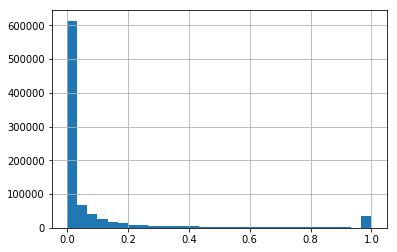

minutes to fill / 93.0 percentile = 1 min


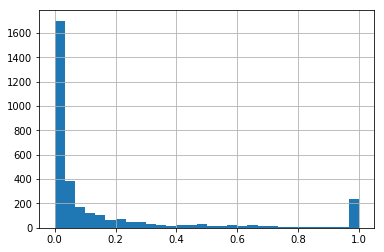

In [18]:
print('minutes to cancel / ', round(stats.percentileofscore(data5a.values, 1),1),' percentile = 1 min', sep='')
data5a.clip(0,1).hist(bins=30); plt.show()

print('minutes to fill / ', round(stats.percentileofscore(data5b.values, 1),1),' percentile = 1 min', sep='')
data5b.clip(0,1).hist(bins=30); plt.show()